The role of viscoelasticity in subducting plates
======

This notebook models a two dimensional viscoelastic subducting plate, as outlined in [Farrington et al, (2014)](http://onlinelibrary.wiley.com/doi/10.1002/2014GC005507/abstract). A dense, high viscosity 3 layered plate overlies a lower viscosity mantle. The upper and lower plate layers have a visco-plastic rheology, yielding under large stress. The middle, core layer has a viscoelastic rheology. The top 600 km of the upper mantle is included. The velocity boundary conditions on the domain are period side, free-slip top and no-slip bottom wall. This notebook reproduces the subducting plate shown in Figure 4(e), highlighting elastic stresses within the slab hinge.

**References**

Farrington, R. J., L.-N. Moresi, and F. A. Capitanio (2014), The role of viscoelasticity in subducting plates, Geochem. Geophys. Geosyst., 15, 4291–4304, http://onlinelibrary.wiley.com/doi/10.1002/2014GC005507/abstract.


![title](input/030 devStressInv-eta2e4-mu8.5e2-dt650.png)
![title](input/030 devStressInv-eta2e4-mu8.5e0-dt800.png)

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np
import os

/Users/rfarrington/Underworld/Underworld2-development/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
outputPath = os.path.join(os.path.abspath("."),"output/")

if uw.rank()==0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
uw.barrier()

**Setup parameters**


In [3]:
# 576 x 128 resolution in paper
xRes = 288 # 576 
yRes = 64  # 128 

**Create mesh and finite element variables**

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"),
                                 elementRes  = (xRes, yRes), 
                                 minCoord    = (0., 0.4), 
                                 maxCoord    = (4., 1.0),
                                 periodic    = [True, False] ) 

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

If reloading from checkpoint, load these files

In [5]:
# ## load mesh, velocity, pressure, temperature & temperatureDot fields via checkpoint files
# step = X
# time = X
# velocityField.load(      outputPath+'velocityField.'+       str(step).zfill(5) +'.h5') 
# pressureField.load(      outputPath+'pressureField.'+       str(step).zfill(5) +'.h5') 

else initialise velocity and pressure field

In [6]:
# set initial conditions (and boundary values)
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

**Create a particle swarm and variables**

In [7]:
swarm = uw.swarm.Swarm( mesh=mesh )
# variables required for model setup
materialVariable       = swarm.add_variable( dataType="int",   count=1 )
previousStress         = swarm.add_variable( dataType="double",count=3 )
# variables required for analysis
dissipation            = swarm.add_variable( dataType="double",count=1 )
storedEneryRate        = swarm.add_variable( dataType="double",count=1 )

If reloading from checkpoint, load these files

In [8]:
# # load swarm, materialVariable and viscosityVariable from checkpoint
# swarm.load(           outputPath +'swarm.'           + str(step).zfill(5) +'.h5')  
# materialVariable.load(outputPath +'materialVariable.'+ str(step).zfill(5) +'.h5')
# previousStress.load(  outputPath +'previousStress.'  + str(step).zfill(5) +'.h5')  
# dissipation.load(     outputPath +'dissipation.'     + str(step).zfill(5) +'.h5')  
# storedEneryRate.load( outputPath +'storedEneryRate.' + str(step).zfill(5) +'.h5')  

else, populate swarm, initialise variables and allocate materials to particles

In [9]:
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )

previousStress.data[:] = [0., 0., 0.]

In [10]:
# initialise the 'materialVariable' data to represent two different materials. 
upperMantleIndex = 1
upperSlabIndex   = 2
lowerSlabIndex   = 3
coreSlabIndex    = 4

# Initial material layout has a flat lying slab with at 15\degree perturbation
slabLowerShape = np.array([ (1.2,0.925 ), (3.25,0.925 ), (3.20,0.900), (1.2,0.900), (1.02,0.825), (1.02,0.850) ])
slabCoreShape  = np.array([ (1.2,0.975 ), (3.35,0.975 ), (3.25,0.925), (1.2,0.925), (1.02,0.850), (1.02,0.900) ])
slabUpperShape = np.array([ (1.2,1.000 ), (3.40,1.000 ), (3.35,0.975), (1.2,0.975), (1.02,0.900), (1.02,0.925) ])

slabLower = fn.shape.Polygon( slabLowerShape )
slabUpper = fn.shape.Polygon( slabUpperShape )
slabCore  = fn.shape.Polygon( slabCoreShape )

In [11]:
# initialise everying to be upper mantle material
materialVariable.data[:] = upperMantleIndex

# change matieral index if the particle is not upper mantle
for index in range( len(swarm.particleCoordinates.data) ):
    coord = swarm.particleCoordinates.data[index][:]
    if slabUpper.evaluate(tuple(coord)):
            materialVariable.data[index] = upperSlabIndex
    if slabLower.evaluate(tuple(coord)):
            materialVariable.data[index] = lowerSlabIndex
    elif slabCore.evaluate(tuple(coord)):
        materialVariable.data[index] = coreSlabIndex

**Plot the initial positions for the particle swarm and colour by material type**


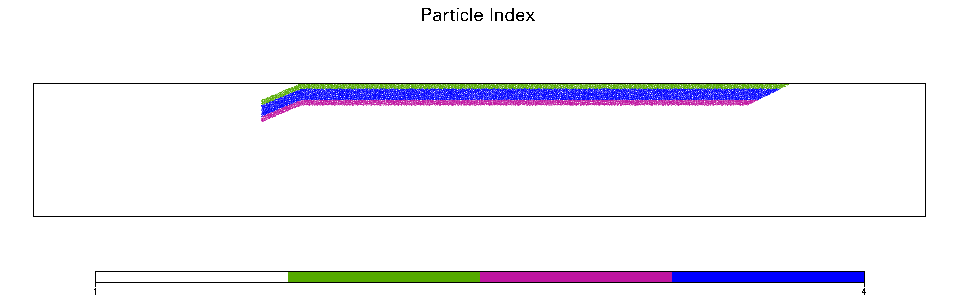

In [12]:
figParticle = glucifer.Figure(figsize=(960,300), title="Particle Index" )
figParticle.append( glucifer.objects.Points(swarm, materialVariable, pointSize=1, 
                                            colours='white green red purple blue', discrete=True) )
figParticle.show()

**Rheology functions**

The upper and lower slab layer weakens under high strain, it has a viscoplastic rheology.  
The slab core maintains strength under high strain, it has a viscoelastic rheology

In [13]:
# define material viscosities
upperMantleViscosity = 1.0   # upper mantle reference viscosity 1.4e19 Pa.s
slabViscosity        = 2.0e2
coreViscosity        = 2.0e4 # shear viscosity

Stress is scaled to SI units using the reference stress, $\tau = \rho g h \, \tau'$ Pa.s

Time is scaled to SI units using the reference viscosity of the upper mantle and stress, $t = \frac{\eta_{um}}{\rho g h} t'$ s

In [14]:
# define core viscoelastic parameters
coreShearModulus        = 8.5e0 # shear modulus = 4.0e9 Pa

alpha   = coreViscosity / coreShearModulus # Maxwell relaxation time = 2e6 yrs
dt_e    = 20.                              # observation timescale of interest = 2e4 yrs
eta_eff = ( coreViscosity * dt_e ) / (alpha + dt_e)  # effective viscosity of viscoelastic slab core

In [15]:
# define strain rate tensor
strainRate = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariant = fn.tensor.second_invariant(strainRate)

# The yeilding of the upper slab is dependent on the strain rate.
cohesion = 0.06
vonMises = 0.5 * cohesion / (strainRate_2ndInvariant+1.0e-18)

# The upper and lower slab viscosity is the minimum of the viscosity and von mises.
slabYieldvisc = fn.exception.SafeMaths( fn.misc.min(vonMises, slabViscosity) )

In [16]:
# Viscosity function for the materials 
viscosityMap = { upperMantleIndex : upperMantleViscosity, 
                 upperSlabIndex   : slabYieldvisc, 
                 lowerSlabIndex   : slabYieldvisc,
                 coreSlabIndex    : eta_eff
               }
viscosityFn  = fn.branching.map( fn_key = materialVariable, mapping = viscosityMap )

**Define stress functions**

In [17]:
# define the viscoelastic stress tensor
viscousStressFn       = 2. * viscosityFn * strainRate 
elasticStressFn       = eta_eff / ( coreShearModulus * dt_e ) * previousStress
viscoelasticStressFn = viscousStressFn + elasticStressFn

# map stress tensor material type
stressMap = { upperMantleIndex : viscousStressFn, 
              upperSlabIndex   : viscousStressFn, 
              lowerSlabIndex   : viscousStressFn,
              coreSlabIndex    : viscoelasticStressFn
            }

stressFn            = fn.branching.map( fn_key=materialVariable, mapping=stressMap )
stress_2ndInvariant = fn.tensor.second_invariant(stressFn)

**Define viscous dissipation and elastic stored energy rate functions**

In [18]:
# from Farrington et al (2014)
viscStrainRateMap = { upperMantleIndex : strainRate, 
                      upperSlabIndex   : strainRate, 
                      lowerSlabIndex   : strainRate,
                      coreSlabIndex    : (strainRate + previousStress/(2.*coreShearModulus*dt_e))*eta_eff/coreViscosity
                    }
viscStrainRateFn = fn.branching.map( fn_key=materialVariable, mapping=viscStrainRateMap )
elStrainRateFn   = strainRate - viscStrainRateFn

dissipationFn = stressFn[0]*viscStrainRateFn[0] + stressFn[1]*viscStrainRateFn[1] + stressFn[2]*viscStrainRateFn[2]
elStoreRateFn = stressFn[0]*elStrainRateFn[0]   + stressFn[1]*elStrainRateFn[1]   + stressFn[2]*elStrainRateFn[2]

**Set the density function, vertical unit vector and Buoyancy Force function**


In [19]:
mantleDensity = 0.0
slabDensity   = 1.0 

densityMap = { upperMantleIndex : mantleDensity, 
               upperSlabIndex   : slabDensity, 
               lowerSlabIndex   : slabDensity, 
               coreSlabIndex    : slabDensity}
densityFn = fn.branching.map( fn_key = materialVariable, mapping = densityMap )

# Define our vertical unit vector using a python tuple
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector
buoyancyFn = -1.0 * densityFn * z_hat

**Set boundary conditions**

In [20]:
topWal     = mesh.specialSets["MaxJ_VertexSet"]
bottomWall = mesh.specialSets["MinJ_VertexSet"]

periodicBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = ( bottomWall, topWal+bottomWall) ) 

**System Setup**

In [21]:
stokes = uw.systems.Stokes(    velocityField    = velocityField, 
                               pressureField    = pressureField,
                               voronoi_swarm    = swarm, 
                               conditions       = periodicBC,
                               fn_viscosity     = viscosityFn, 
                               fn_bodyforce     = buoyancyFn,
                               fn_stresshistory = elasticStressFn, # include stress history term
                          )
# Create solver & solve
solver = uw.systems.Solver(stokes)

In [22]:
# use "lu" direct solve if running in serial
if(uw.nProcs()==1):
    solver.set_inner_method("lu")

In [23]:
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )

**Analysis tools**

In [24]:
#The root mean square Velocity
velSquared = uw.utils.Integral( fn.math.dot(velocityField,velocityField), mesh )
area = uw.utils.Integral( 1., mesh )
Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )

In [25]:
#Plot of Velocity Magnitude
figVelocityMag = glucifer.Figure(figsize=(960,300), title="Velocity magnitude" )
figVelocityMag.append( glucifer.objects.Surface(mesh, fn.math.sqrt(fn.math.dot(velocityField,velocityField)), onMesh=True) )

#Plot of Strain Rate, 2nd Invariant
figStrainRate = glucifer.Figure(figsize=(960,300), title="Strain rate 2nd invariant" )
figStrainRate.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, onMesh=True) )

#Plot of particles viscosity
figViscosity = glucifer.Figure(figsize=(960,300), title="Viscosity" )
figViscosity.append( glucifer.objects.Points(swarm, viscosityFn, pointSize=2) )

#Plot of particles stress invariant
figStress = glucifer.Figure(figsize=(960,300), title="Stress 2nd invariant"  )
figStress.append( glucifer.objects.Points(swarm, stress_2ndInvariant, pointSize=2, logScale=True) )


In [26]:
# Plot of core Weissenberg number
Wi = alpha * strainRate_2ndInvariant  # Weissenberg number
materialFilter = materialVariable > 3

figWi = glucifer.Figure(figsize=(960,300), title='Weissenberg number')
weissenbergGL = glucifer.objects.Points(swarm, Wi, pointSize=1, fn_mask = materialFilter, logScale=True, 
                                        valueRange=[1.e-4, 1e0], colours='blue cyan green yellow orange red',
                                       )
weissenbergGL.colourBar["tickvalues"] = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]

figWi.append( weissenbergGL )

In [27]:
# create dissipation field
dissipationField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
dissipationProjector = uw.utils.MeshVariable_Projection( dissipationField, dissipation, type=0 )
dissipationProjector.solve()

# plot dissipation field
coreDissipationGL    = glucifer.objects.Points(swarm, dissipation, pointSize=1, fn_mask=materialFilter, 
                                                logScale=True, valueRange=[1.e-6, 2.5e-4])
coreDissipationGL.colourBar["tickvalues"] = [1e-6, 1e-5, 1e-4, 2.5e-4]

figDissipation = glucifer.Figure(figsize=(960,300), title="Dissipation per unit volume")
figDissipation.append( coreDissipationGL )

In [28]:
#Plot of elastic stored rate
coreElStorageRateGL = glucifer.objects.Points(swarm, storedEneryRate, pointSize=2, fn_mask=materialFilter,
                                              valueRange=[-7.e-4, 7.e-4])                                              

figElStoreRate = glucifer.Figure(figsize=(960,300), title="Elastic stored energy rate per unit volume")
figElStoreRate.append( coreElStorageRateGL )

In [29]:
# only update stress history for viscoelastic material
veStressMap = { upperMantleIndex : [0., 0., 0.], 
                upperSlabIndex   : [0., 0., 0.], 
                lowerSlabIndex   : [0., 0., 0.],
                coreSlabIndex    : viscoelasticStressFn
            }
veStressFn = fn.branching.map( fn_key=materialVariable, mapping=veStressMap )

In [30]:
# Plot of particles stress invariant
veStress_2ndInvariant = fn.math.sqrt(0.5*(veStressFn[0]**2+veStressFn[1]**2+veStressFn[2]**2))
coreStressGL = glucifer.objects.Points(swarm, veStress_2ndInvariant*4.8e8/1e9, pointSize=2, 
                                              fn_mask=materialFilter, valueRange=[0, 1.5], 
                                              colours='white blue cyan green yellow orange red',
                                             )
coreStressGL.colourBar["tickvalues"] = [0., 0.5, 1.0, 1.5]
figCoreStress = glucifer.Figure(figsize=(960,300), title="Core Stress 2nd invariant [GPa]", 
#                                boundingBox=((1.85,0.8), (2.5,1.))
                               )
figCoreStress.append(coreStressGL)


**Update time step, stress history, advect particles**

In [31]:
# define an update function
def update():
    
    # Retrieve the maximum possible timestep for the advection system.
    dt = advector.get_max_dt() 
    if dt > ( dt_e / 3. ): # cap dt for observation time, dte/3.
        dt = dt_e / 3.  
        
    # smoothed stress history for use in (t + 1) timestep   
    phi = dt / dt_e;
    veStressFn_data = veStressFn.evaluate(swarm) # previous stress = 0 for non ve material

    # save stress to be transported with particle
    previousStress.data[:] = ( phi*veStressFn_data[:] + ( 1.-phi )*previousStress.data[:] )

    # Advect using this timestep size.
    advector.integrate(dt)
    
    return time+dt, step+1

**Checkpointing function definition**

In [32]:
meshHnd = mesh.save(   outputPath+'mesh.00000.h5')
def checkpoint():
    # update field and swarm variables
    dissipation.data[:]     = dissipationFn.evaluate(swarm)
    storedEneryRate.data[:] = elStoreRateFn.evaluate(swarm)

    dissipationProjector.solve()

    # save swarm and swarm variables
    swarmHnd            = swarm.save(           outputPath+'swarm.'           + str(step).zfill(5) +'.h5')
    materialVariableHnd = materialVariable.save(outputPath+'materialVariable.'+ str(step).zfill(5) +'.h5')
    previousStressHnd   = previousStress.save(  outputPath+'previousStress.'  + str(step).zfill(5) +'.h5')
    dissipationHnd      = dissipation.save(     outputPath+'dissipation.'     + str(step).zfill(5) +'.h5')
    storedEnergyHnd     = storedEneryRate.save( outputPath+'storedEneryRate.' + str(step).zfill(5) +'.h5')
    
    # save mesh variables
    velocityHnd     = velocityField.save(       outputPath+'velocityField.'       + str(step).zfill(5) +'.h5', meshHnd)
    pressureHnd     = pressureField.save(       outputPath+'pressureField.'       + str(step).zfill(5) +'.h5', meshHnd)
    
    # and the xdmf files
    materialVariable.xdmf(outputPath+'materialVariable.'+str(step).zfill(5)+'.xdmf',
                       materialVariableHnd,"materialVariable",swarmHnd,"swarm",modeltime=time)
    previousStress.xdmf(  outputPath+'previousStress.'  +str(step).zfill(5)+'.xdmf',
                       previousStressHnd,  "previousStress",  swarmHnd,"swarm",modeltime=time)
    dissipation.xdmf(    outputPath+'dissipation.'      +str(step).zfill(5)+'.xdmf',
                       dissipationHnd,     "dissipation",     swarmHnd,"swarm",modeltime=time)
    storedEneryRate.xdmf(outputPath+'storedEneryRate.'  +str(step).zfill(5)+'.xdmf',
                       storedEnergyHnd,    "storedEnergy",    swarmHnd,"swarm",modeltime=time)
    
    velocityField.xdmf(       outputPath+'velocityField.'       +str(step).zfill(5)+'.xdmf',
                       velocityHnd,     "velocity",      meshHnd, "mesh",modeltime=time)
    pressureField.xdmf(       outputPath+'pressureField.'       +str(step).zfill(5)+'.xdmf',
                       pressureHnd,     "pressure",      meshHnd, "mesh",modeltime=time)

    # save visualisation
    figParticle.save(    outputPath + "particle."    + str(step).zfill(5))
    figVelocityMag.save( outputPath + "velocityMag." + str(step).zfill(5))
    figStrainRate.save(  outputPath + "strainRate."  + str(step).zfill(5))
    figViscosity.save(   outputPath + "viscosity."   + str(step).zfill(5))
    figStress.save(      outputPath + "stress."      + str(step).zfill(5))
    figDissipation.save( outputPath + "dissipation." + str(step).zfill(5))
    figElStoreRate.save( outputPath + "elStoreRate." + str(step).zfill(5))
    figCoreStress.save(  outputPath + "coreStress."  + str(step).zfill(5))
    figWi.save(          outputPath + "stress."      + str(step).zfill(5))


Main simulation loop
=======

The main time stepping loop begins here. Inside the time loop the velocity field is solved for via the Stokes system solver and then the swarm is advected using the advector integrator. Basic statistics are output to screen each timestep.

In [33]:
time = 0.  # Initial time
step = 0   # Initial timestep

In [34]:
maxSteps = 6      # Maximum timesteps (1201 to reproduce figure)
steps_output = 5   # output every 10 timesteps

In [35]:
while step < maxSteps:
    # Solve non linear Stokes system
    solver.solve(nonLinearIterate=True)
    # output figure to file at intervals = steps_output
    if step % steps_output == 0 or step == maxSteps-1:
        checkpoint()
        Vrms = math.sqrt( velSquared.evaluate()[0]/area.evaluate()[0] )
        print 'step = {0:6d}; time = {1:.3e}; Vrms = {2:.3e}'.format(step,time,Vrms)
    # update
    time,step = update()

step =      0; time = 0.000e+00; Vrms = 6.623e-05
step =      5; time = 3.333e+01; Vrms = 5.990e-05


**Post simulation visualisation**


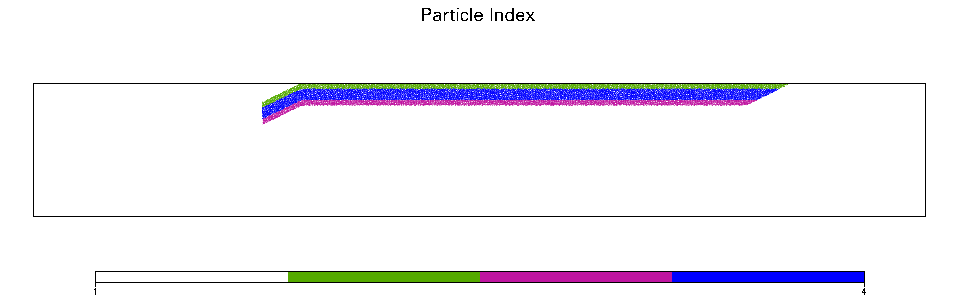


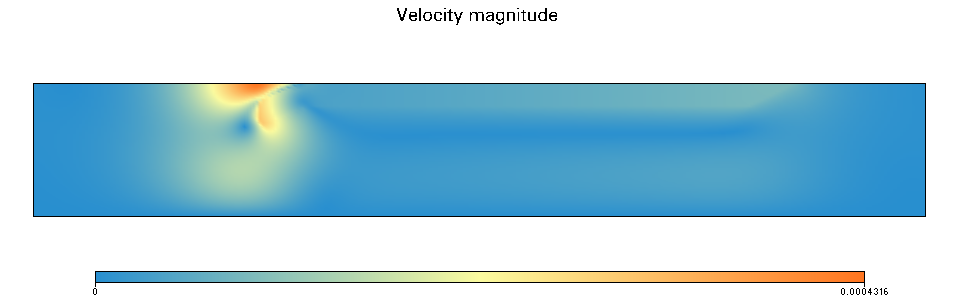


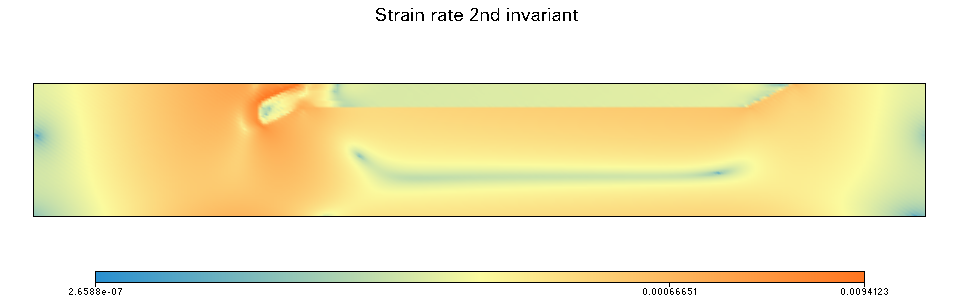


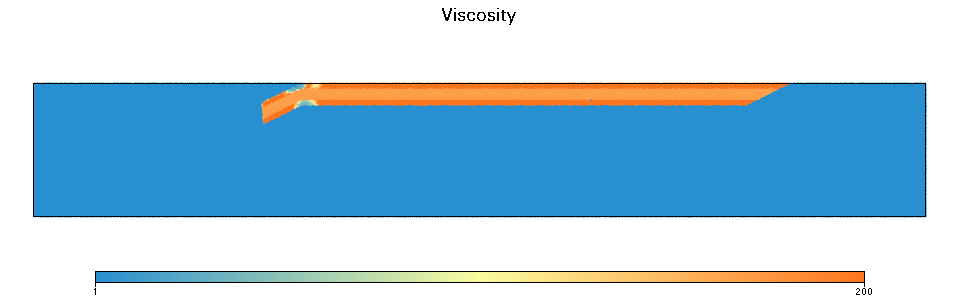


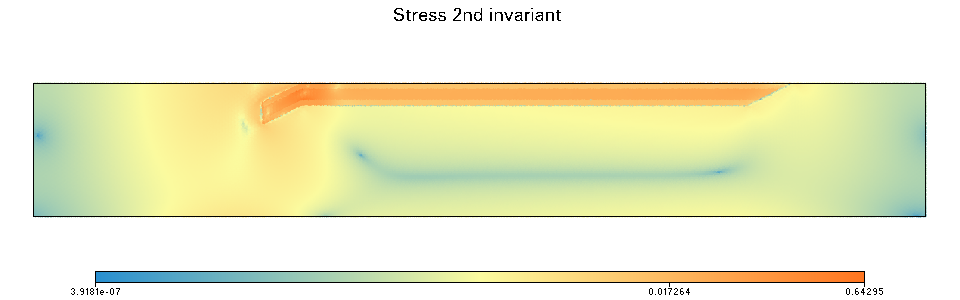

In [36]:
figParticle.show()
figVelocityMag.show()
figStrainRate.show()
figViscosity.show()
figStress.show()


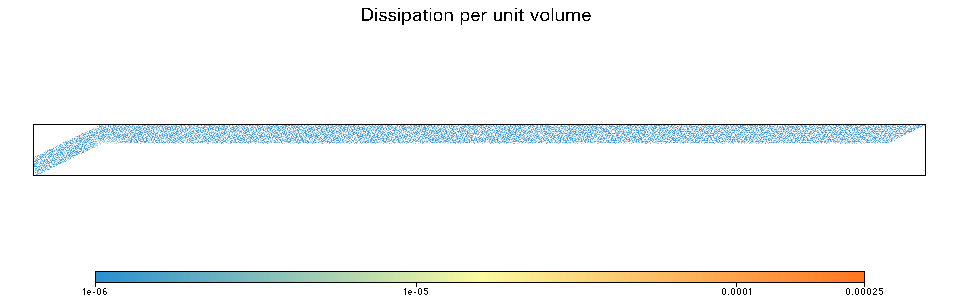


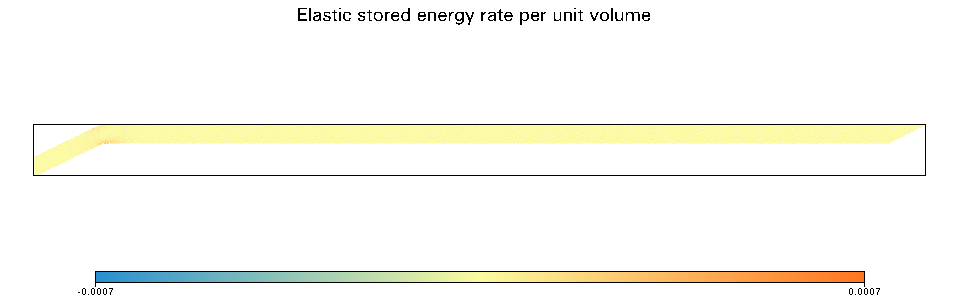


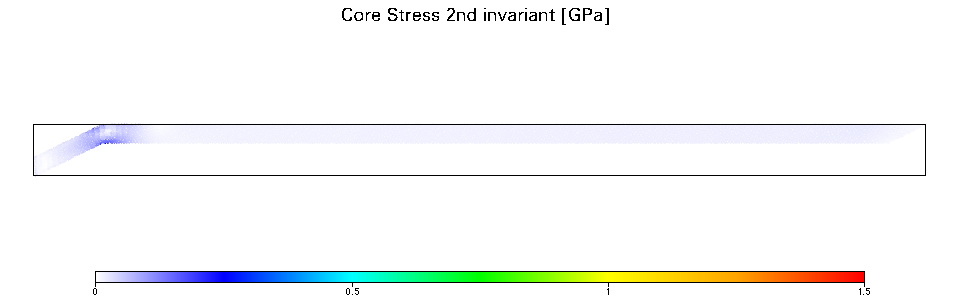


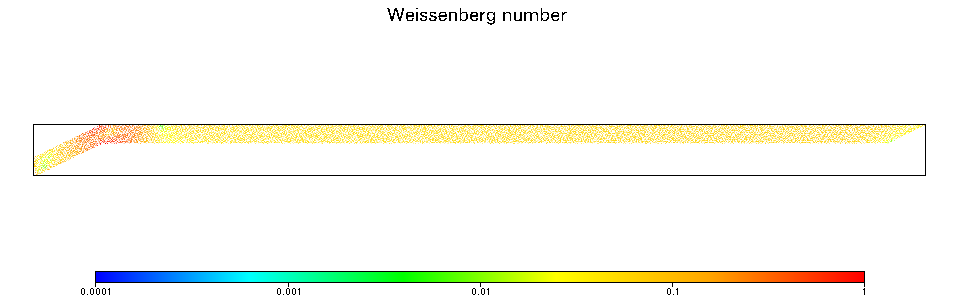

In [37]:
figDissipation.show()
figElStoreRate.show()
figCoreStress.show()
figWi.show()

In [38]:
# save visualisation
figParticle.save(    outputPath + "particle."    + str(step).zfill(5))
figVelocityMag.save( outputPath + "velocityMag." + str(step).zfill(5))
figStrainRate.save(  outputPath + "strainRate."  + str(step).zfill(5))
figViscosity.save(   outputPath + "viscosity."   + str(step).zfill(5))
figStress.save(      outputPath + "stress."      + str(step).zfill(5))
figWi.save(          outputPath + "wi."          + str(step).zfill(5))
figDissipation.save( outputPath + "dissipation." + str(step).zfill(5))
figElStoreRate.save( outputPath + "elStoreRate." + str(step).zfill(5))
figCoreStress.save(  outputPath + "coreStress."  + str(step).zfill(5))


'/Users/rfarrington/Underworld/Underworld2-development/docs/publications/FarringtonEtAl-2014/output/coreStress.00006.png'


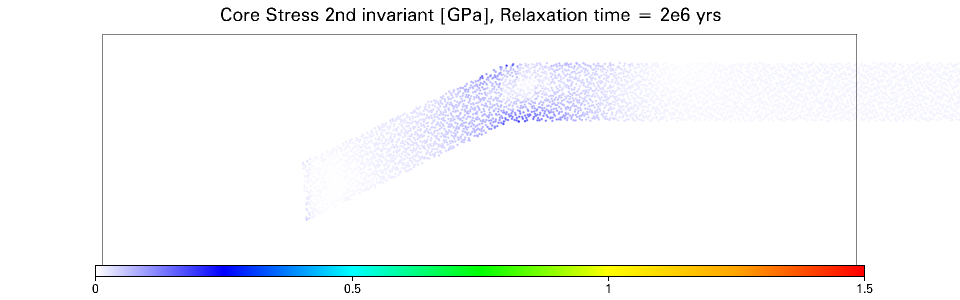

In [40]:
coreStressGL = glucifer.objects.Points(swarm, veStress_2ndInvariant*4.8e8/1e9, pointSize=3, 
                                              fn_mask=materialFilter, valueRange=[0, 1.5], 
                                              colours='white blue cyan green yellow orange red',
                                             )
coreStressGL.colourBar["tickvalues"] = [0., 0.5, 1.0, 1.5]
figCoreStress = glucifer.Figure(figsize=(960,300), title="Core Stress 2nd invariant [GPa], Relaxation time = 2e6 yrs", 
                                boundingBox=((0.85,0.8), (1.5,1.)), quality=2
                               )
figCoreStress.append(coreStressGL)
figCoreStress.show()